In [1]:
import json
from pathlib import Path

import numba
import numpy as np

from utils.measure_and_compare import measure_and_compare, reset_measure_and_compare
from utils.preparation import get_segmentation, plot

reset_measure_and_compare()

In [2]:
def load_data(path):
    segments = []
    counts = []
    centers = []
    for json_path in sorted(path.glob("*.json"), key=lambda p: int(p.stem)):
        with open(json_path) as f:
            data = json.load(f)
            segments.append(data["segments"])
            counts.append(data["counts"])
            centers.append(data["centers"])
    return segments, counts, centers


def combine_stats(chunked_segments, chunked_counts, chunked_centers):
    counts_per_segment = {}
    centers_per_segement = {}
    for segments_i, counts_i, centers_i in zip(
        chunked_segments, chunked_counts, chunked_centers
    ):
        for segment, count, center in zip(segments_i, counts_i, centers_i):
            counts_per_segment.setdefault(segment, []).append(count)
            centers_per_segement.setdefault(segment, []).append(center)

    result_segments = []
    result_counts = []
    result_centers = []
    for segment in counts_per_segment.keys():
        center_x = 0
        center_y = 0
        count_sum = 0
        for count, center in zip(
            counts_per_segment[segment], centers_per_segement[segment]
        ):
            center_x += center[0] * count
            center_y += center[1] * count
            count_sum += count

        result_segments.append(segment)
        result_counts.append(count_sum)
        result_centers.append((center_x / count_sum, center_y / count_sum))
    return result_segments, result_counts, result_centers


def load_and_combine_stats(path):
    chunked_stats = load_data(path)
    return combine_stats(*chunked_stats)

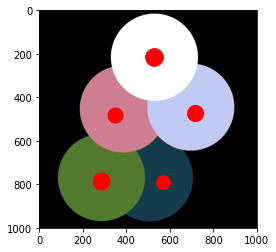

In [3]:
combined_stats = load_and_combine_stats(Path("data/small"))

segmentation = get_segmentation()
plot(segmentation, combined_stats)

# Profiling

In [4]:
%%timeit
load_and_combine_stats(Path("data/large"))

15.4 s ± 593 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
import yappi

yappi.set_clock_type("cpu")
yappi.clear_stats()
yappi.start()
_ = load_and_combine_stats(Path("data/large"))
yappi.stop()
yappi.get_func_stats().print_all()


Clock type: CPU
Ordered by: totaltime, desc

name                                  ncall  tsub      ttot      tavg      
..:3483 ZMQInteractiveShell.run_code  1      0.000017  59.39702  59.39702
..nel_15257/2801445275.py:6 <module>  1      0.413383  59.39698  59.39698
..65336.py:44 load_and_combine_stats  1      0.053888  58.98350  58.98350
..5257/339865336.py:14 combine_stats  1      21.66024  39.29477  39.29477
..nel_15257/339865336.py:1 load_data  1      0.602757  19.63484  19.63484
..ython3.7/json/__init__.py:274 load  10000  0.050002  18.25148  0.001825
..thon3.7/json/__init__.py:299 loads  10000  0.043793  17.84126  0.001784
../decoder.py:332 JSONDecoder.decode  10000  0.080255  17.78021  0.001778
..oder.py:343 JSONDecoder.raw_decode  10000  17.63666  17.63667  0.001764
..3.7/pathlib.py:1091 PosixPath.glob  10001  0.017548  0.261054  0.000026
..516 _WildcardSelector._select_from  10001  0.106270  0.243425  0.000024
..s.py:319 IncrementalDecoder.decode  10000  0.030140  0.124473 

In [6]:
from os import getpid
from subprocess import DEVNULL, Popen

from IPython.display import FileLink, display

py_spy_process = Popen(
    [
        "py-spy",
        "record",
        "--native",
        "--subprocesses",
        "--nolineno",
        "-o",
        "profiles/flamegraph.svg",
        "--duration",
        "35",
        "--pid",
        str(getpid()),
    ],
    stdout=DEVNULL,
)

_ = load_and_combine_stats(Path("data/large"))

py_spy_process.wait()
display(FileLink("profiles/flamegraph.svg"))

/home/jonathan/code/data-analysis-speedup/profiles/flamegraph.svg

In [7]:
@measure_and_compare()
def load_and_combine_stats(path):
    chunked_stats = load_data(path)
    return combine_stats(*chunked_stats)

In [8]:
combined_stats = load_and_combine_stats(Path("data/large"), max_time=35)

22.28s (28.92s wall)  load_and_combine_stats(data/large)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats__data_large.svg

# Efficient IO

In [9]:
import h5py


def load_data_hdf5(path):
    segments = []
    counts = []
    centers = []
    for hdf5_path in sorted(path.glob("*.hdf5"), key=lambda p: int(p.stem)):
        with h5py.File(hdf5_path, "r") as f:
            segments.append(f["segments"][:])
            counts.append(f["counts"][:])
            centers.append(f["centers"][:])
    return segments, counts, centers


@measure_and_compare()
def load_and_combine_stats_v1(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats(*chunked_stats)

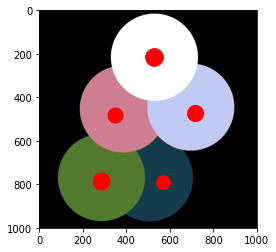

14.47s (27.11s wall) load_and_combine_stats_v1(data/large), 54.04% faster (load_and_combine_stats was 22.28s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_v1__data_large.svg

In [10]:
combined_stats = load_and_combine_stats_v1(Path("data/small"))

plot(segmentation, combined_stats)

combined_stats = load_and_combine_stats_v1(Path("data/large"), max_time=30)

# Vectorization

In [11]:
def combine_stats_numpy(chunked_stats):
    chunked_segments, chunked_counts, chunked_centers = chunked_stats
    counts_per_segment = {}
    centers_per_segement = {}
    for segments_i, counts_i, centers_i in zip(
        chunked_segments, chunked_counts, chunked_centers
    ):
        for segment, count, center in zip(segments_i, counts_i, centers_i):
            counts_per_segment.setdefault(segment, []).append(count)
            centers_per_segement.setdefault(segment, []).append(center)

    result_segments = []
    result_counts = []
    result_centers = []
    for segment in counts_per_segment.keys():
        segment_counts = np.array(counts_per_segment[segment])
        segment_centers = np.array(centers_per_segement[segment])
        count_sum = segment_counts.sum()
        center = (segment_centers * segment_counts[:, np.newaxis]).sum(
            axis=0
        ) / count_sum
        result_segments.append(segment)
        result_counts.append(count_sum)
        result_centers.append(center)
    return result_segments, result_counts, result_centers


@measure_and_compare()
def load_and_combine_stats_v2(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats_numpy(chunked_stats)

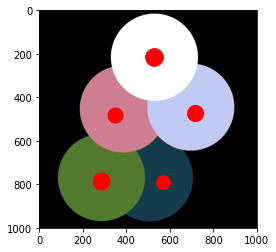

12.79s (23.71s wall) load_and_combine_stats_v2(data/large), 74.22% faster (load_and_combine_stats was 22.28s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_v2__data_large.svg

In [12]:
combined_stats = load_and_combine_stats_v2(Path("data/small"))

plot(segmentation, combined_stats)

combined_stats = load_and_combine_stats_v2(Path("data/large"), max_time=25)

In [13]:
def combine_stats_numpy_fast_groupby(chunked_stats):
    all_segments = np.concatenate([i for i in chunked_stats[0] if len(i) > 0])
    all_counts = np.concatenate([i for i in chunked_stats[1] if len(i) > 0])
    all_centers = np.concatenate([i for i in chunked_stats[2] if len(i) > 0])

    # sort all arrays by all_segments
    sort_idx = np.argsort(all_segments)
    all_segments = all_segments[sort_idx]
    all_counts = all_counts[sort_idx]
    all_centers = all_centers[sort_idx]

    # group by segments (g_idx is where the groups start)
    g_segments, g_idx = np.unique(all_segments, return_index=True)
    g_counts = np.split(all_counts, g_idx[1:])
    g_centers = np.split(all_centers, g_idx[1:])

    # empty arrays for results
    segments = np.ndarray(len(g_segments), dtype=all_segments.dtype)
    counts = np.ndarray(len(g_segments), dtype=all_counts.dtype)
    centers = np.ndarray((len(g_segments), 2), dtype=all_centers.dtype)

    # combine stats for each segment
    for i, (segment, segment_counts, segment_centers) in enumerate(
        zip(g_segments, g_counts, g_centers)
    ):
        count_sum = segment_counts.sum()
        center = (segment_centers * segment_counts[:, np.newaxis]).sum(
            axis=0
        ) / count_sum
        segments[i] = segment
        counts[i] = count_sum
        centers[i] = center
    return segments, counts, centers


@measure_and_compare()
def load_and_combine_stats_v3(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats_numpy_fast_groupby(chunked_stats)

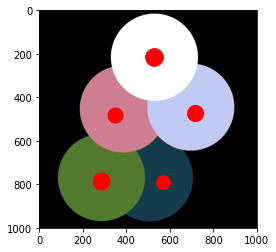

 8.04s (16.74s wall) load_and_combine_stats_v3(data/large), 177.14% faster (load_and_combine_stats was 22.28s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_v3__data_large.svg

In [14]:
combined_stats = load_and_combine_stats_v3(Path("data/small"))

plot(segmentation, combined_stats)

combined_stats = load_and_combine_stats_v3(Path("data/large"))

# Memory & Precision Tradeoffs

In [15]:
def combine_stats_numpy_fast_groupby(chunked_stats):
    all_segments = np.concatenate(
        [i.astype(np.uint32) for i in chunked_stats[0] if len(i) > 0]
    )
    all_counts = np.concatenate(
        [i.astype(np.uint32) for i in chunked_stats[1] if len(i) > 0]
    )
    all_centers = np.concatenate(
        [i.astype(np.float32) for i in chunked_stats[2] if len(i) > 0]
    )

    # sort all arrays by all_segments
    sort_idx = np.argsort(all_segments)
    all_segments = all_segments[sort_idx]
    all_counts = all_counts[sort_idx]
    all_centers = all_centers[sort_idx]

    # group by segments (g_idx is where the groups start)
    g_segments, g_idx = np.unique(all_segments, return_index=True)
    g_counts = np.split(all_counts, g_idx[1:])
    g_centers = np.split(all_centers, g_idx[1:])

    # empty arrays for results
    segments = np.ndarray(len(g_segments), dtype=all_segments.dtype)
    counts = np.ndarray(len(g_segments), dtype=all_counts.dtype)
    centers = np.ndarray((len(g_segments), 2), dtype=all_centers.dtype)

    # combine stats for each segment
    for i, (segment, segment_counts, segment_centers) in enumerate(
        zip(g_segments, g_counts, g_centers)
    ):
        count_sum = segment_counts.sum()
        center = (segment_centers * segment_counts[:, np.newaxis]).sum(
            axis=0
        ) / count_sum
        segments[i] = segment
        counts[i] = count_sum
        centers[i] = center
    return segments, counts, centers


@measure_and_compare()
def load_and_combine_stats_v4(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats_numpy_fast_groupby(chunked_stats)

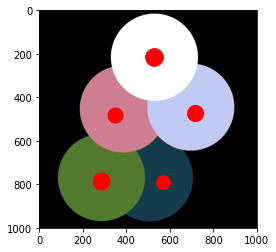

 7.56s (15.86s wall) load_and_combine_stats_v4(data/large), 194.68% faster (load_and_combine_stats was 22.28s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_v4__data_large.svg

In [16]:
combined_stats = load_and_combine_stats_v4(Path("data/small"))

plot(segmentation, combined_stats)

combined_stats = load_and_combine_stats_v4(Path("data/large"))

# Jit-ting with numba

In [17]:
@numba.njit
def combine_stats_per_segment(segment_counts, segment_centers):
    count_sum = segment_counts.sum()
    center = (segment_centers * segment_counts[:, np.newaxis]).sum(axis=0) / count_sum
    return count_sum, center


def combine_stats_numpy_fast_groupby_numba(chunked_stats):
    all_segments = np.concatenate(
        [i.astype(np.uint32) for i in chunked_stats[0] if len(i) > 0]
    )
    all_counts = np.concatenate(
        [i.astype(np.uint32) for i in chunked_stats[1] if len(i) > 0]
    )
    all_centers = np.concatenate(
        [i.astype(np.float32) for i in chunked_stats[2] if len(i) > 0]
    )
    sort_idx = np.argsort(all_segments)
    all_segments = all_segments[sort_idx]
    all_counts = all_counts[sort_idx]
    all_centers = all_centers[sort_idx]
    g_segments, g_idx = np.unique(all_segments, return_index=True)
    g_counts = np.split(all_counts, g_idx[1:])
    g_centers = np.split(all_centers, g_idx[1:])

    def empty_array(other):
        return np.ndarray((len(other),) + other[0].shape[1:], dtype=other[0].dtype)

    segments = empty_array(g_segments)
    counts = empty_array(g_counts)
    centers = empty_array(g_centers)
    for i, (segment, segment_counts, segment_centers) in enumerate(
        zip(g_segments, g_counts, g_centers)
    ):
        count_sum, center = combine_stats_per_segment(segment_counts, segment_centers)
        segments[i] = segment
        counts[i] = count_sum
        centers[i] = center
    return segments, counts, centers


@measure_and_compare()
def load_and_combine_stats_v5(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats_numpy_fast_groupby_numba(chunked_stats)

In [18]:
combined_stats = load_and_combine_stats_v5(Path("data/large"))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(uint32, 1d, C), Tuple(slice<a:b>, none))
 
There are 22 candidate implementations:
  - Of which 20 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(array(uint32, 1d, C), Tuple(slice<a:b>, none))':
   No match.
  - Of which 2 did not match due to:
  Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 166.
    With argument(s): '(array(uint32, 1d, C), Tuple(slice<a:b>, none))':
   Rejected as the implementation raised a specific error:
     NumbaTypeError: unsupported array index type none in Tuple(slice<a:b>, none)
  raised from /home/jonathan/.cache/pypoetry/virtualenvs/data-analysis-speedup-Yl14xPLQ-py3.7/lib/python3.7/site-packages/numba/core/typing/arraydecl.py:73

During: typing of intrinsic-call at /tmp/ipykernel_15257/1199427906.py (4)
During: typing of static-get-item at /tmp/ipykernel_15257/1199427906.py (4)

File "../../../../tmp/ipykernel_15257/1199427906.py", line 4:
<source missing, REPL/exec in use?>


In [19]:
@numba.njit()
def combine_stats_per_segment(segment_counts, segment_centers):
    count_sum = segment_counts.sum()
    center = (segment_centers * segment_counts.reshape((-1, 1))).sum(axis=0) / count_sum
    return count_sum, center

In [20]:
combined_stats = load_and_combine_stats_v5(Path("data/large"))
combined_stats = load_and_combine_stats_v5(Path("data/large"))

 8.34s (16.35s wall) load_and_combine_stats_v5(data/large), 167.15% faster (load_and_combine_stats was 22.28s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_v5__data_large.svg

 7.61s (16.17s wall) load_and_combine_stats_v5(data/large), 192.88% faster (load_and_combine_stats was 22.28s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_v5__data_large.svg